In [2]:
from pm4py import *
from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.objects.conversion.process_tree import converter as pt_converter

import pandas as pd
from datetime import date
import seaborn as sns

## 1.Загрузка бизнес-процесса и преобразование его в сеть Петри

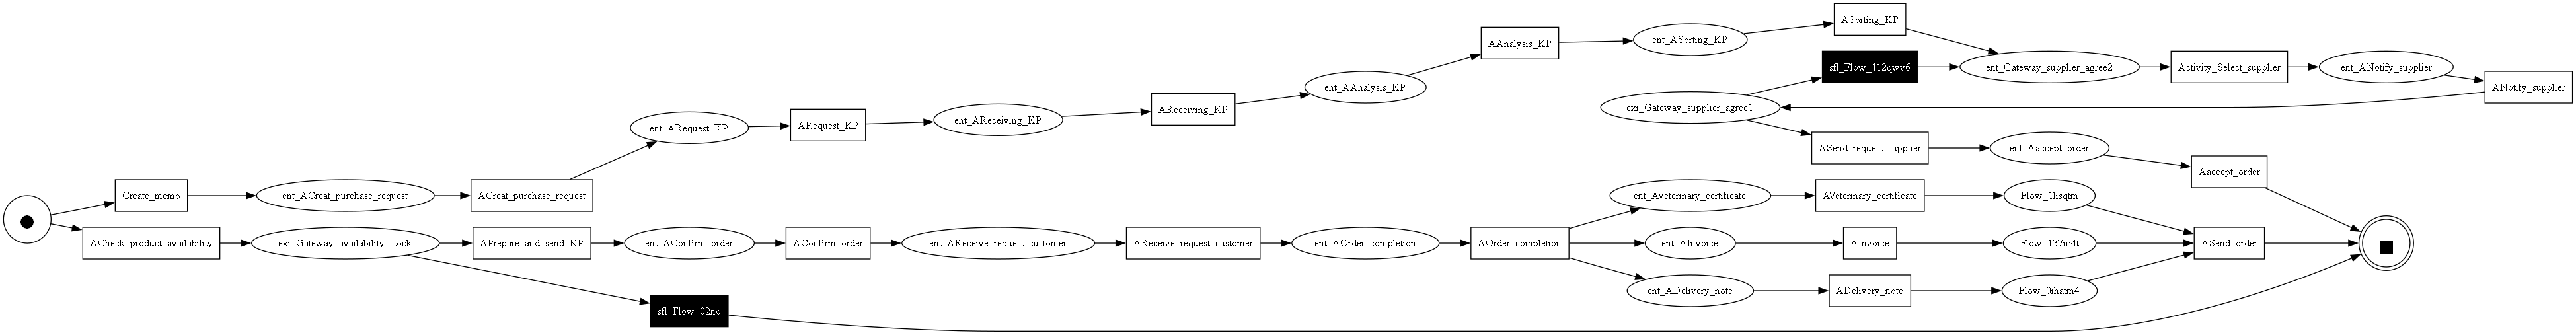

In [3]:
bpmn_graph = read_bpmn('diag_D.bpmn')
net,im,fm = convert_to_petri_net(bpmn_graph)

gviz = pn_visualizer.apply(
    net,
    im,
    fm,
    parameters={"debug": True, "set_rankdir": "LR"} # set_rankdir for horizontal layout
)

# Render and view the graph
pn_visualizer.view(gviz)


In [4]:
#from pm4py.algo.analysis.woflan.graphs import minimal_coverability_graph
#import os


#mcg=minimal_coverability_graph.minimal_coverability_graph.minimal_coverability_tree(net, im, fm)

#from pm4py.algo.analysis.woflan.graphs.minimal_coverability_graph import apply as minimal_coverability_graph
#mcg = minimal_coverability_graph(net, initial_marking)




## 2.Построение графа покрытия и достижимости маркировок


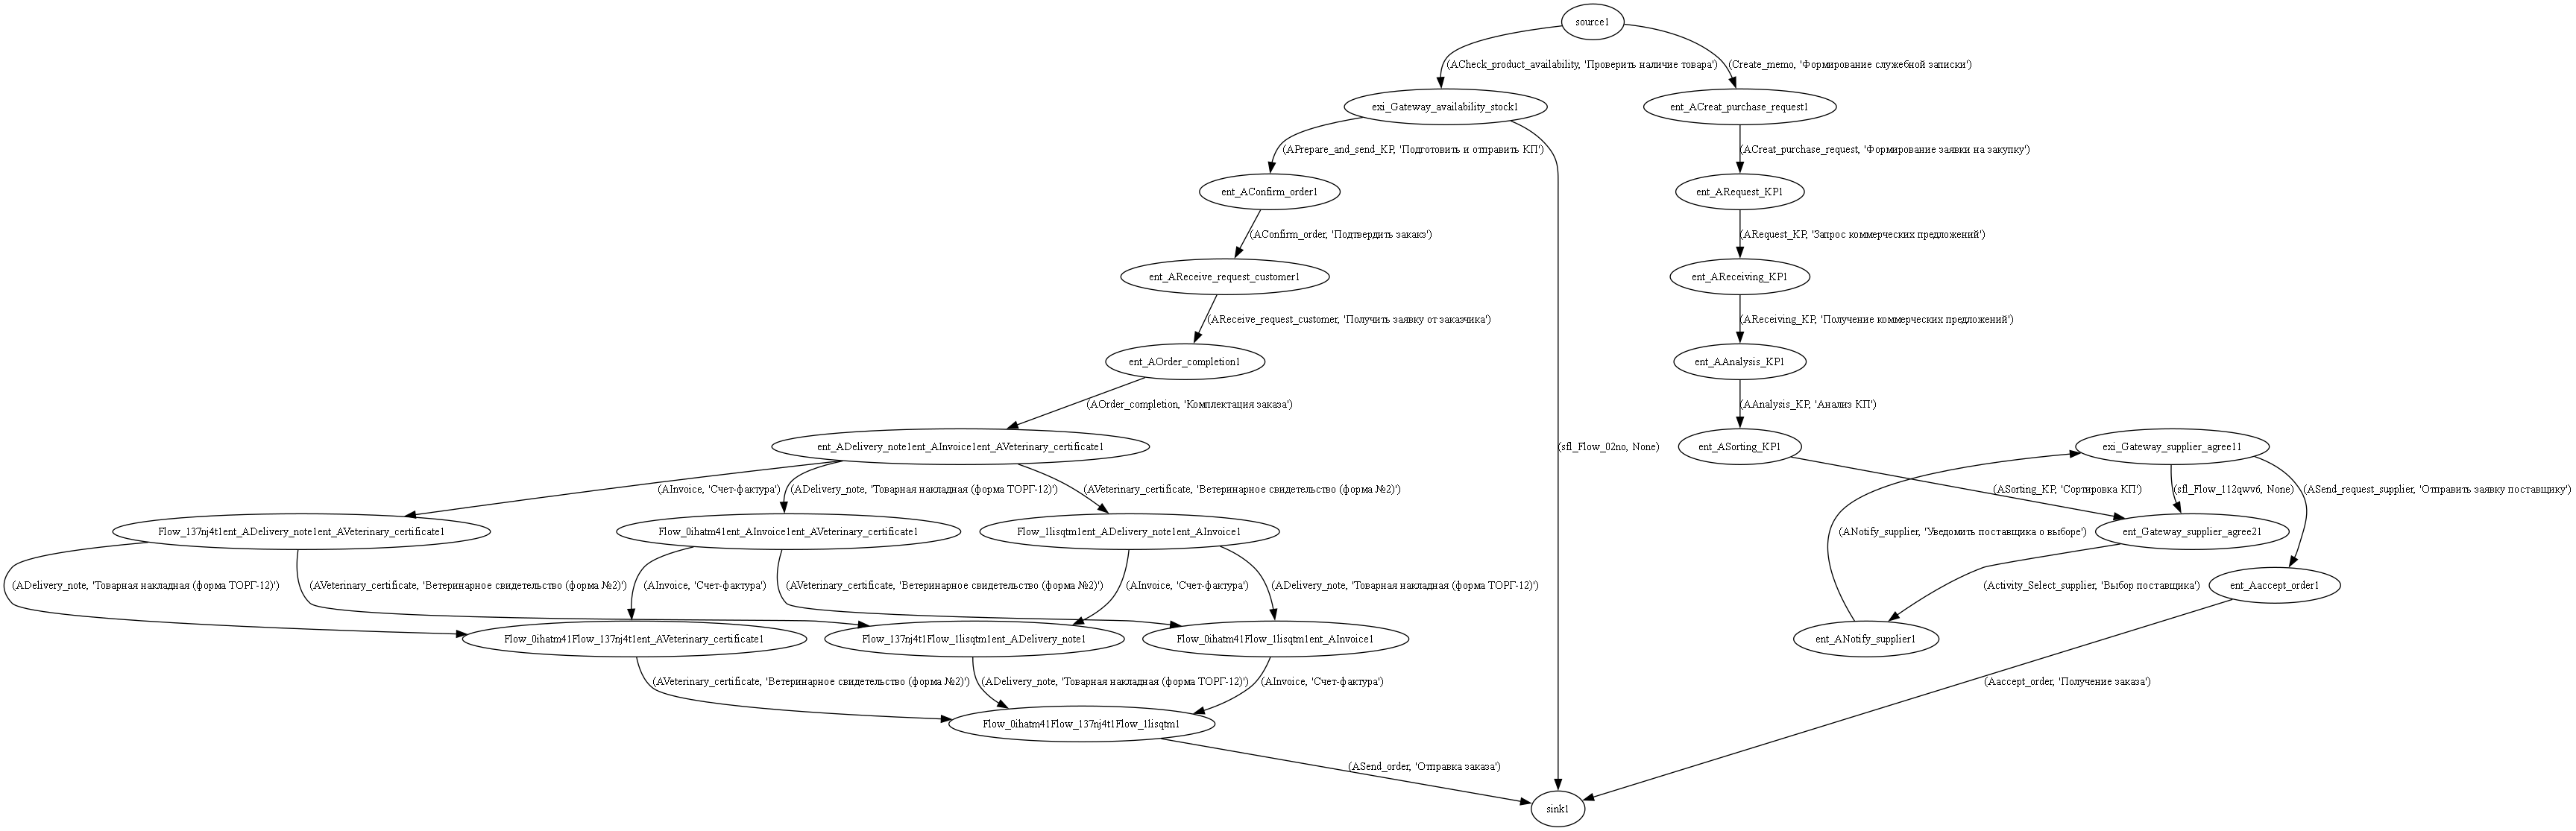

In [5]:

net, initial_marking, final_marking = convert_to_petri_net(bpmn_graph)

from pm4py.objects.petri_net.utils import reachability_graph

#конструируем граф достижимости встроенными средствами 
ts=reachability_graph.construct_reachability_graph(net,initial_marking)

from pm4py.visualization.transition_system import visualizer as ts_visualizer

gviz=ts_visualizer.apply(ts,parameters={ts_visualizer.Variants.VIEW_BASED.value.Parameters.FORMAT:"png"})
ts_visualizer.view(gviz)



In [6]:
#построения графа покрытия маркировок и графа достижимости маркировок срдествами woflan 

from pm4py.algo.analysis.woflan.graphs.minimal_coverability_graph import minimal_coverability_graph
from pm4py.algo.analysis.woflan.graphs.reachability_graph import reachability_graph
import pygraphviz as pgv 
from IPython.display import Image, display
from matplotlib import pyplot as plt

#граф покрытия 
cg=minimal_coverability_graph.apply(net, initial_marking, final_marking)

#граф достижимости
rg=reachability_graph.apply(net, initial_marking, final_marking)


    



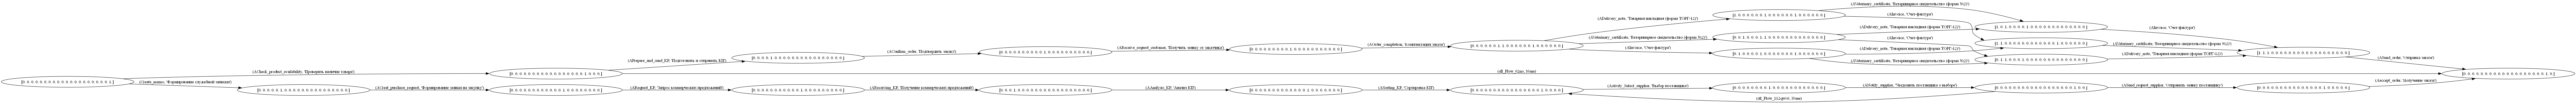

True

In [7]:
def vizualizeGraph(network):#визуализация графа покрытия маркировок и проверка на неограниченность
    is_bounded=True
    GR = pgv.AGraph(strict=False, directed=True)
    GR.graph_attr['rankdir'] = 'LR'
    GR.node_attr['shape'] = 'ellipse'


    for node, attributes in network.nodes(data=True):
        marking = attributes['marking']
        for pos in marking:
            if(pos==float('inf')):
                is_bounded=False
              
        GR.add_node(node, label=marking)
        
    for e in network.edges(data=True):
        GR.add_edge(e[0], e[1], label=e[2]['transition'], penwidth=1)
 

    GR.layout(prog='dot')  # Layout algorithm (e.g., 'dot', 'neato', 'fdp', 'circo')
    display(Image(GR.draw(format='png')))
    return is_bounded

vizualizeGraph(cg)

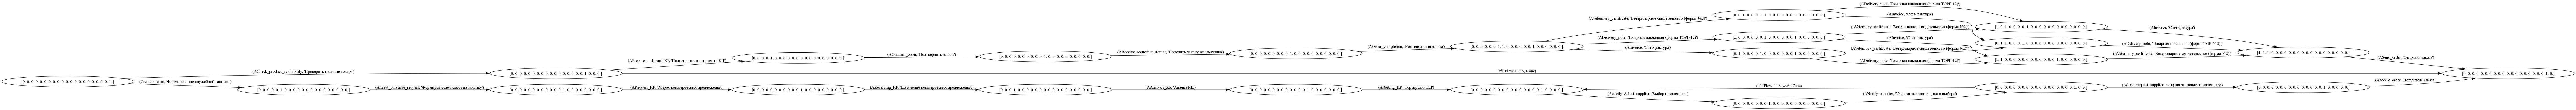

True

In [8]:
vizualizeGraph(rg)

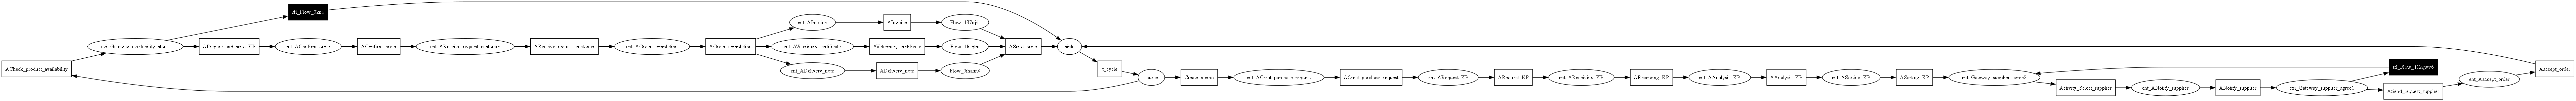

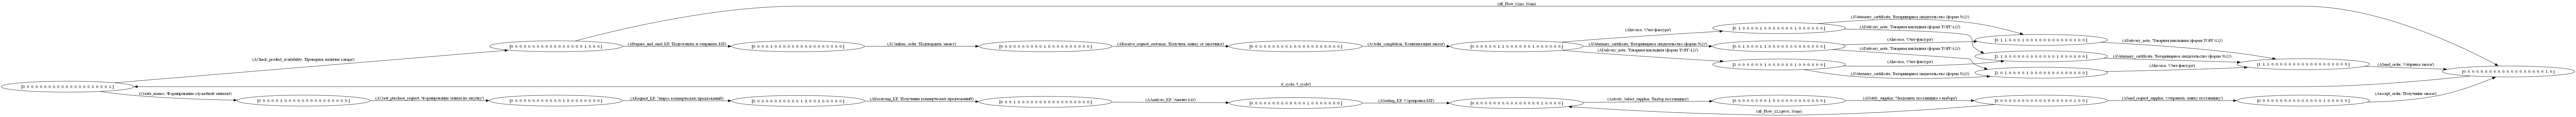

Is bounded?: True


In [9]:
from pm4py.objects.petri_net.utils import petri_utils
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

from pm4py.objects.petri_net.obj import PetriNet, Marking



import copy


# делаем копию сети
net_copy = copy.deepcopy(net)



# добавляем X - переход и проверяем на ограниченность 

def add_cycle_transition(pn: PetriNet, first_place: PetriNet.Place, last_place: PetriNet.Place):
    """
    Добавляет переход, который берёт токен из последнего места
    и кладёт его в первое место.
    """
    # создаём переход
    t_cycle = PetriNet.Transition("t_cycle", "t_cycle")

    # добавляем переход в сеть
    pn.transitions.add(t_cycle)

    # дуги: last_place → t_cycle → first_place
    petri_utils.add_arc_from_to(last_place, t_cycle, pn)
    petri_utils.add_arc_from_to(t_cycle, first_place, pn)
    return t_cycle


#вычисляем начальные и конечные позиции
begin_places = [place for place, tokens in im.items() if tokens > 0]

final_places = [place for place, tokens in fm.items() if tokens > 0]

# создаём переход
t_cycle = PetriNet.Transition("t_cycle", "t_cycle")

# добавляем переход в сеть
net_copy.transitions.add(t_cycle)


#получить реальную позицию (объект) по ключу из маркировки

def get_place_by_name(pn, name):
    for place in pn.places:
        if place.name == name:
            return place
    return None  # если места с таким именем нет




p_fin = next(iter(fm.keys()))   # объект Place
p_beg = next(iter(im.keys()))   # объект Place
p_Fin = get_place_by_name (net_copy, p_fin.name)
p_Beg = get_place_by_name (net_copy, p_beg.name)


#добавляем дуги
petri_utils.add_arc_from_to(p_Fin, t_cycle, net_copy)
petri_utils.add_arc_from_to( t_cycle,p_Beg, net_copy)


#покажем расширенную сетку
gviz = pn_visualizer.apply(
    net_copy,
    im,
    fm,
    parameters={"debug": True, "set_rankdir": "LR"} # set_rankdir for horizontal layout
)

# отобразим 
pn_visualizer.view(gviz)


# строим граф покрытия маркировок расширенной сети  и там же проверяем на ограниченность (нет омег)

cg_ext=minimal_coverability_graph.apply(net_copy, initial_marking, final_marking)
is_bounded=vizualizeGraph(cg_ext)
print("Is bounded?:",is_bounded)

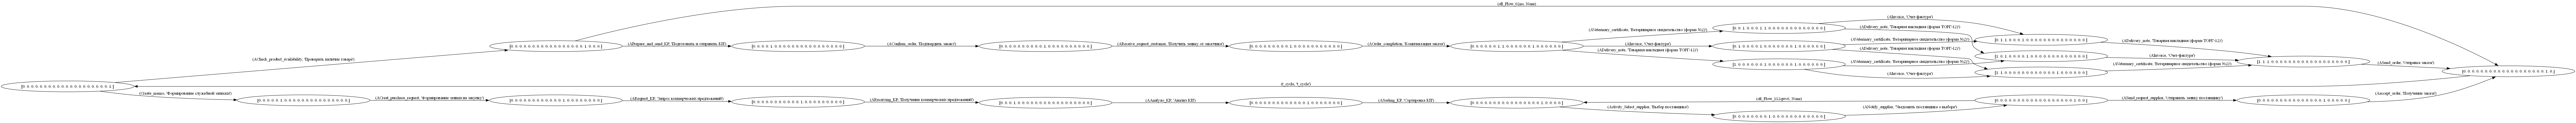

Is live
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}]


In [10]:
import networkx as nx

#TODO: надо добавить проверку на ограниченность. Вопрос - зачем?

rg_ext=reachability_graph.apply(net_copy, initial_marking, final_marking)
vizualizeGraph(rg_ext)

#проверяем на живость расширенную сеть
#вычисляем сильносвязные компоненты. Для живости компонента должна быть одна и каждый переход сети должен ей принадлежать 


scc = list(nx.strongly_connected_components(rg_ext))
if len(scc)==1:
    print("Is live")
else:
    print("Not live")

# Вопрос - ДОПОЛНИТЬ проверкой, что каждый переход сетки входит в компоненту SCC (Задание) 
print(scc)

# Если компонента сильной связности расширенной сети Петри одна и ей принадлежат все переходы, то делаем вывод, что сеть живая  
#
#



## 3.Анализ бездефектности 
**WOFLAN**

In [11]:
net, initial_marking, final_marking = convert_to_petri_net(bpmn_graph)

from pm4py.algo.analysis.woflan import algorithm as woflan

is_sound = woflan.apply(net, initial_marking, final_marking, parameters={woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND: True,
                                                     woflan.Parameters.PRINT_DIAGNOSTICS: True,
                                                                          
                                                     woflan.Parameters.RETURN_DIAGNOSTICS: True})

print("\nIs Workflow net sound? ->", is_sound[0])

print("\n Полная статистика",is_sound[1])


Input is ok.
Petri Net is a workflow net.
Every place is covered by s-components.
There are no dead tasks.
All tasks are live.

Is Workflow net sound? -> True

 Полная статистика {'s_c_net': places: [ Flow_0ihatm4, Flow_137nj4t, Flow_1lisqtm, ent_AAnalysis_KP, ent_AConfirm_order, ent_ACreat_purchase_request, ent_ADelivery_note, ent_AInvoice, ent_ANotify_supplier, ent_AOrder_completion, ent_AReceive_request_customer, ent_AReceiving_KP, ent_ARequest_KP, ent_ASorting_KP, ent_AVeterinary_certificate, ent_Aaccept_order, ent_Gateway_supplier_agree2, exi_Gateway_availability_stock, exi_Gateway_supplier_agree1, sink, source ]
transitions: [ (AAnalysis_KP, 'Анализ КП'), (ACheck_product_availability, 'Проверить наличие товара'), (AConfirm_order, 'Подтвердить закакз'), (ACreat_purchase_request, 'Формирование заявки на закупку'), (ADelivery_note, 'Товарная накладная (форма ТОРГ-12)'), (AInvoice, 'Счет-фактура'), (ANotify_supplier, 'Уведомить поставщика о выборе'), (AOrder_completion, 'Комплектация

c:\Users\Alber\OneDrive\Desktop\Магистратура\1 курс\СППР\pr3\graph\Lib\site-packages\pm4py\algo\analysis\woflan\place_invariants\utility.py:163: UserWarning: solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.
  warnings.warn(


## 4.Генерация журнала событий 

c:\Users\Alber\OneDrive\Desktop\Магистратура\1 курс\СППР\pr3\graph\Lib\site-packages\pm4py\utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
c:\Users\Alber\OneDrive\Desktop\Магистратура\1 курс\СППР\pr3\graph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
exporting log, completed traces :: 100%|██████████| 50/50 [00:00<00:00, 7351.46it/s]


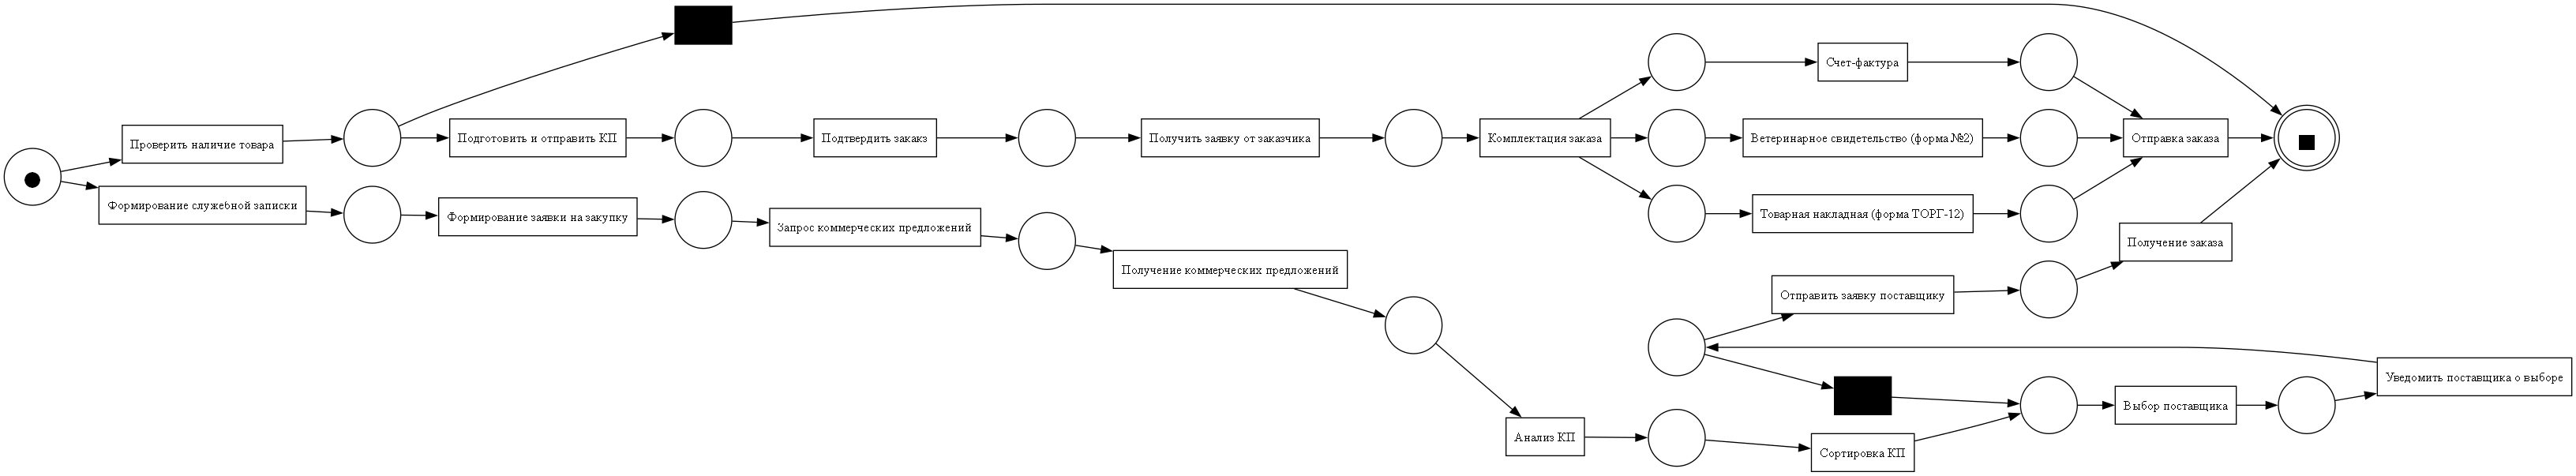

In [12]:
simulated_log = simulator.apply(net, initial_marking, variant=simulator.Variants.BASIC_PLAYOUT,
                                    parameters={simulator.Variants.BASIC_PLAYOUT.value.Parameters.NO_TRACES: 50})

write_xes(simulated_log, 'log.xes')

gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

dataframe = convert_to_dataframe(simulated_log)
dataframe.to_csv('exp.csv')


In [13]:
df = pd.read_csv("exp.csv", index_col=0)
df = df.rename(columns={"case:concept:name": "client", "time:timestamp": "datetime", "concept:name": "action"})
df['resource']=''
df.head(20)

,action,datetime,client,resource
0,Проверить наличие товара,1970-04-26 20:46:40+00:00,0,
1,Формирование служебной записки,1970-04-26 20:46:41+00:00,1,
2,Формирование заявки на закупку,1970-04-26 20:46:42+00:00,1,
3,Запрос коммерческих предложений,1970-04-26 20:46:43+00:00,1,
4,Получение коммерческих предложений,1970-04-26 20:46:44+00:00,1,
5,Анализ КП,1970-04-26 20:46:45+00:00,1,
6,Сортировка КП,1970-04-26 20:46:46+00:00,1,
7,Выбор поставщика,1970-04-26 20:46:47+00:00,1,
8,Уведомить поставщика о выборе,1970-04-26 20:46:48+00:00,1,
9,Отправить заявку поставщику,1970-04-26 20:46:49+00:00,1,


In [14]:
student_case = ['Выбрать направление', 
                  'Проходить курсы', 
                  'Выбрать проекты',
                  'Выбрать доп. услуги',
                  'Сделать проекты',
                  'Ходить на языковую подготовку',
                  'Ходить в спортзал']

council_case = ['Регистрация заявления студента', 
                'Рассмотреть заявление',
                'Принять решение по заявлению',
                'Проверить ранее пройденные дисциплины',
                'Отправить уведомления о зачислении']

prof_case = ['Решить насчет дат',
                'Назначить другой день сдачи',
                'Согласовать проекты',
                'Проверить работы',
                'Поставить оценку']

for row_inx in range(df.shape[0]):
    if df.iloc[row_inx, 0] in student_case:
        df.loc[row_inx, 'resource'] = 'Студент'
    elif df.iloc[row_inx, 0] in council_case:
        df.loc[row_inx, 'resource'] = 'Приемная комиссия'
    elif df.iloc[row_inx, 0] in prof_case:
        df.loc[row_inx, 'resource'] = 'Преподаватель'

In [15]:
df.head(20)

,action,datetime,client,resource
0,Проверить наличие товара,1970-04-26 20:46:40+00:00,0,
1,Формирование служебной записки,1970-04-26 20:46:41+00:00,1,
2,Формирование заявки на закупку,1970-04-26 20:46:42+00:00,1,
3,Запрос коммерческих предложений,1970-04-26 20:46:43+00:00,1,
4,Получение коммерческих предложений,1970-04-26 20:46:44+00:00,1,
5,Анализ КП,1970-04-26 20:46:45+00:00,1,
6,Сортировка КП,1970-04-26 20:46:46+00:00,1,
7,Выбор поставщика,1970-04-26 20:46:47+00:00,1,
8,Уведомить поставщика о выборе,1970-04-26 20:46:48+00:00,1,
9,Отправить заявку поставщику,1970-04-26 20:46:49+00:00,1,


In [16]:
df.to_csv('log.csv')

## 5.Предварительный анализ журнала событий

In [17]:
events = pd.read_csv('log.csv', index_col=0)
events['datetime'] = pd.to_datetime(events['datetime'])
events.head()

,action,datetime,client,resource
0,Проверить наличие товара,1970-04-26 20:46:40+00:00,0,NaN
1,Формирование служебной записки,1970-04-26 20:46:41+00:00,1,NaN
2,Формирование заявки на закупку,1970-04-26 20:46:42+00:00,1,NaN
3,Запрос коммерческих предложений,1970-04-26 20:46:43+00:00,1,NaN
4,Получение коммерческих предложений,1970-04-26 20:46:44+00:00,1,NaN


In [18]:
print(f'Event log has {events.shape[0]} rows and {events.shape[1]} columns.')

Event log has 364 rows and 4 columns.


In [19]:
## Get the case start times to get the time deltas for the 'age' of each activity with respect to start
case_starts_ends = events.pivot_table(index='client', aggfunc={'datetime': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['client', 'caseend', 'casestart']
events = events.merge(case_starts_ends, on='client')
events['relativetime'] = (events['caseend']) - events['casestart']

## Get day of week
events['weekday'] = events['datetime'].apply(lambda x: x.weekday())
events['date'] = events['datetime'].apply(lambda x: x.date())
events['startdate'] = events['casestart'].apply(lambda x: x.date())
events['hour'] = events['datetime'].apply(lambda x: x.time().hour)
## Get relative times in more friendly terms
events['relativetime_s'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days
events['relativedays'] = events['relativetime'].dt.days

events.head()

,action,datetime,client,resource,caseend,casestart,relativetime,weekday,date,startdate,hour,relativetime_s,relativedays
0,Проверить наличие товара,1970-04-26 20:46:40+00:00,0,NaN,1970-04-26 20:46:40+00:00,1970-04-26 20:46:40+00:00,0 days 00:00:00,6,1970-04-26,1970-04-26,20,0,0
1,Формирование служебной записки,1970-04-26 20:46:41+00:00,1,NaN,1970-04-26 20:46:50+00:00,1970-04-26 20:46:41+00:00,0 days 00:00:09,6,1970-04-26,1970-04-26,20,9,0
2,Формирование заявки на закупку,1970-04-26 20:46:42+00:00,1,NaN,1970-04-26 20:46:50+00:00,1970-04-26 20:46:41+00:00,0 days 00:00:09,6,1970-04-26,1970-04-26,20,9,0
3,Запрос коммерческих предложений,1970-04-26 20:46:43+00:00,1,NaN,1970-04-26 20:46:50+00:00,1970-04-26 20:46:41+00:00,0 days 00:00:09,6,1970-04-26,1970-04-26,20,9,0
4,Получение коммерческих предложений,1970-04-26 20:46:44+00:00,1,NaN,1970-04-26 20:46:50+00:00,1970-04-26 20:46:41+00:00,0 days 00:00:09,6,1970-04-26,1970-04-26,20,9,0


### Точечная диаграмма

In [20]:
patientnums = [int(e) for e in events['client'].apply(lambda x: str(x).strip('client'))]
resourcenums = [i for (i, e) in enumerate(events['resource'])]

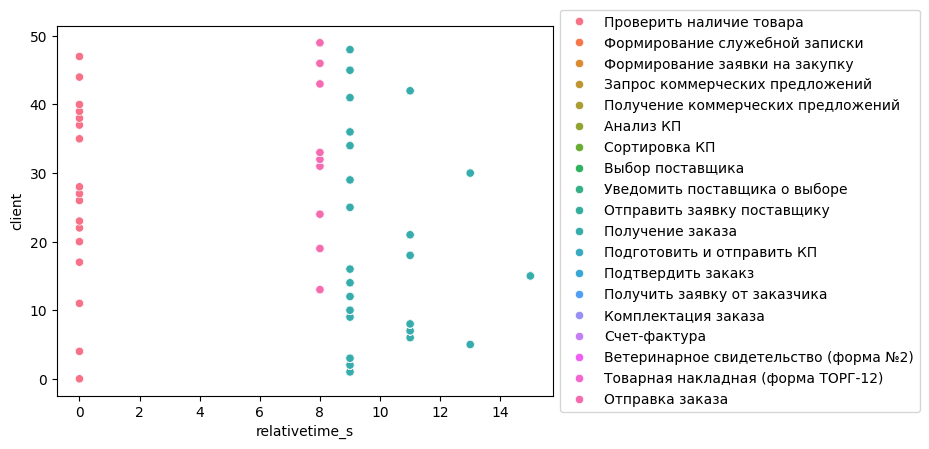

In [21]:
ax = sns.scatterplot(x=events['relativetime_s'], y=events['client'], hue=events['action'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

In [22]:
# test_df = events[events['action'] == 'Принятие заявки']
# patientnums = [int(e) for e in test_df['client'].apply(lambda x: str(x).strip('client'))]
# resourcenums = [i for (i, e) in enumerate(test_df['resource'])]
# ax = sns.scatterplot(x=test_df['relativetime_s'], y=test_df['client'], hue=test_df['action'])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

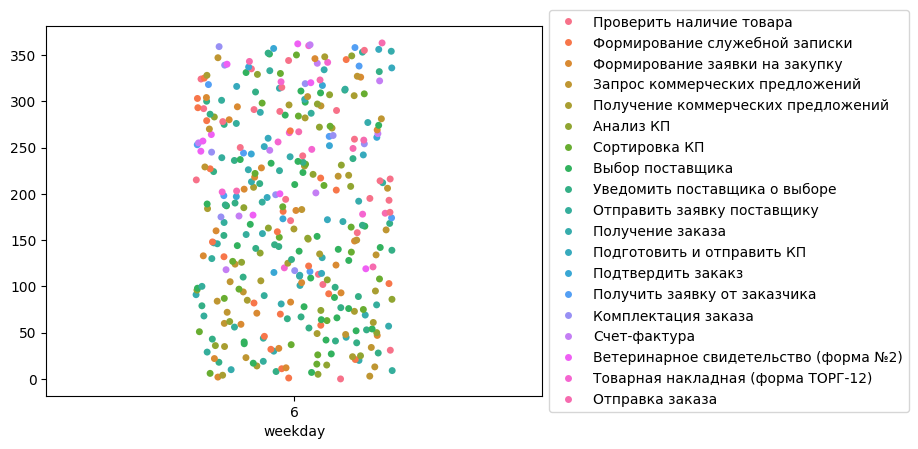

In [23]:
ax = sns.stripplot(x=events['weekday'], y=resourcenums, hue=events['action'], jitter=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

## 6.Реконструкция процесса алгоритмами ProcessMining

### Альфа майнер

replaying log with TBR, completed traces :: 100%|██████████| 10/10 [00:00<00:00, 1474.63it/s]


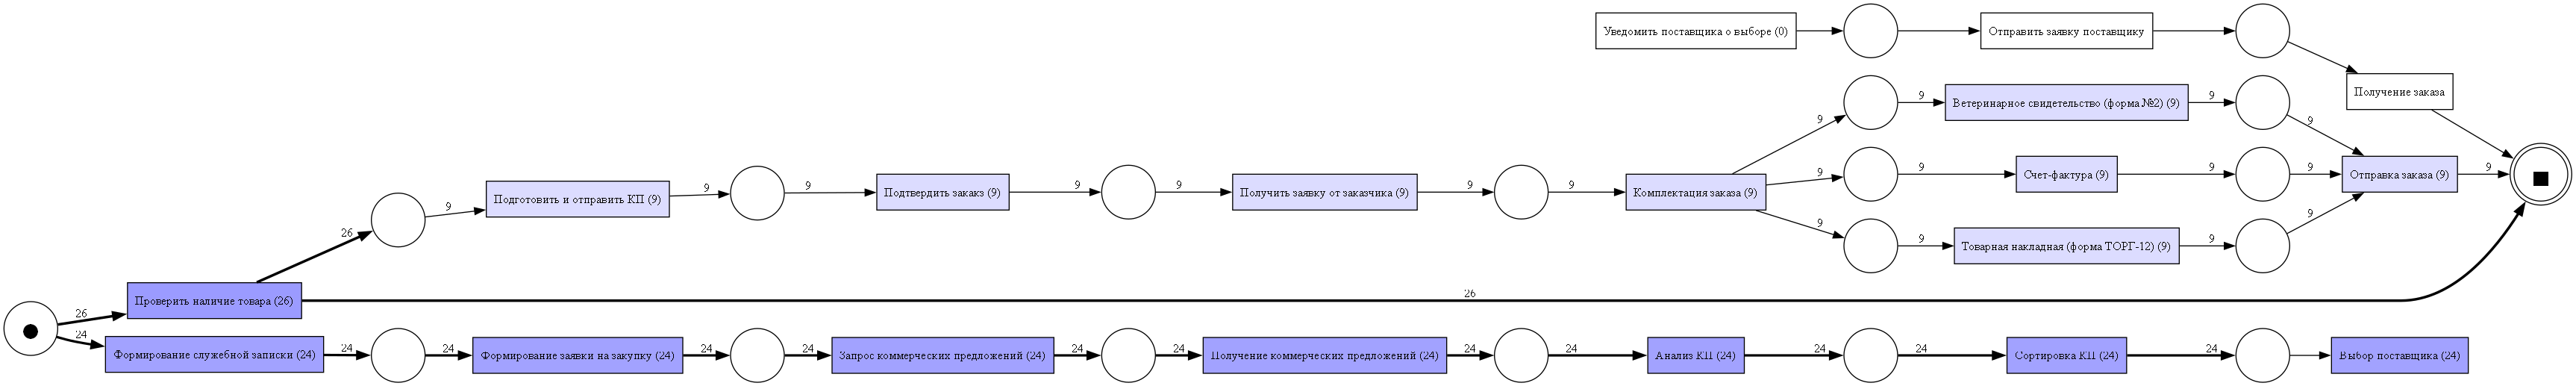

In [24]:
# alpha miner
simulated_log = read_xes('log.xes')

net, initial_marking, final_marking = alpha_miner.apply(simulated_log)

# Visualise
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                            parameters=parameters,
                            variant=pn_visualizer.Variants.FREQUENCY,
                            log=simulated_log)
pn_visualizer.view(gviz)

### Альфа+ майнер

parsing log, completed traces :: 100%|██████████| 50/50 [00:00<00:00, 4995.95it/s]
C:\Users\Alber\AppData\Local\Temp\ipykernel_6760\3565787422.py:4: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. This method will be removed in a future release.
  net, initial_marking, final_marking = discover_petri_net_alpha_plus(simulated_log)
replaying log with TBR, completed traces :: 100%|██████████| 10/10 [00:00<00:00, 1025.08it/s]


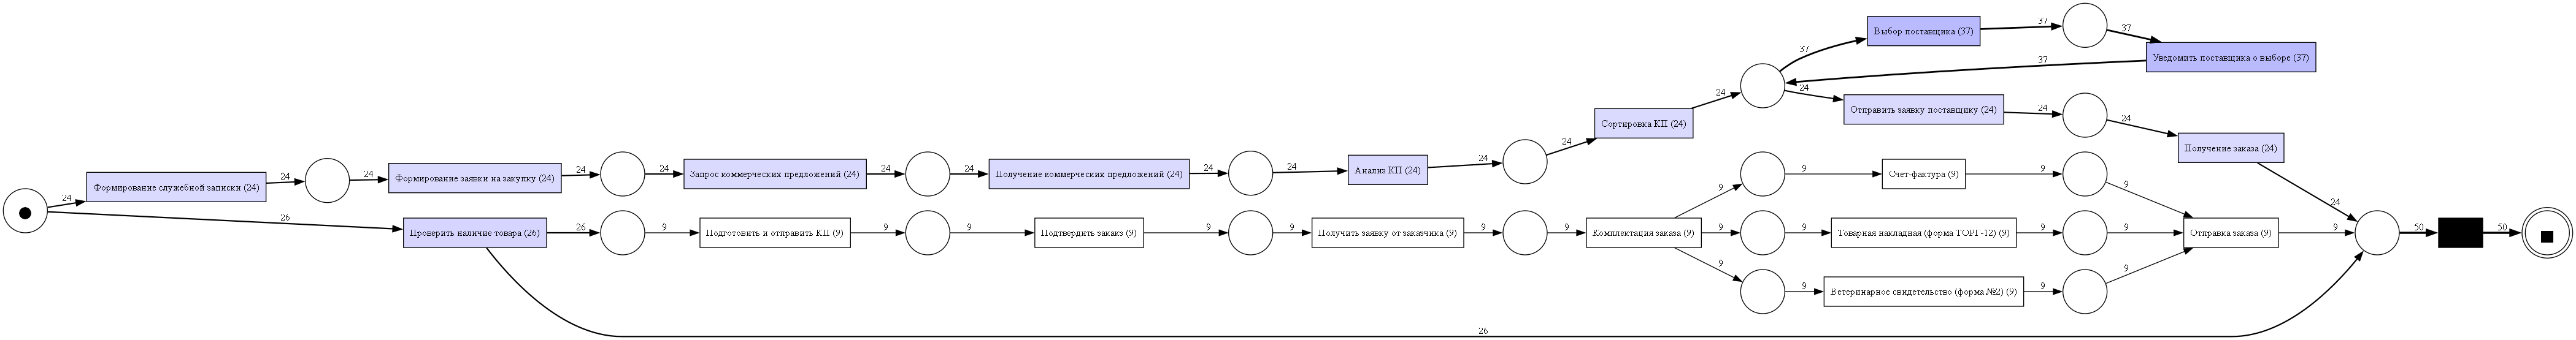

In [25]:
# alpha miner
simulated_log = read_xes('log.xes')

net, initial_marking, final_marking = discover_petri_net_alpha_plus(simulated_log)

# Visualise
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                            parameters=parameters,
                            variant=pn_visualizer.Variants.FREQUENCY,
                            log=simulated_log)
pn_visualizer.view(gviz)

### Эвристический майнер

parsing log, completed traces ::   0%|          | 0/50 [00:00<?, ?it/s]

parsing log, completed traces :: 100%|██████████| 50/50 [00:00<00:00, 3781.85it/s]


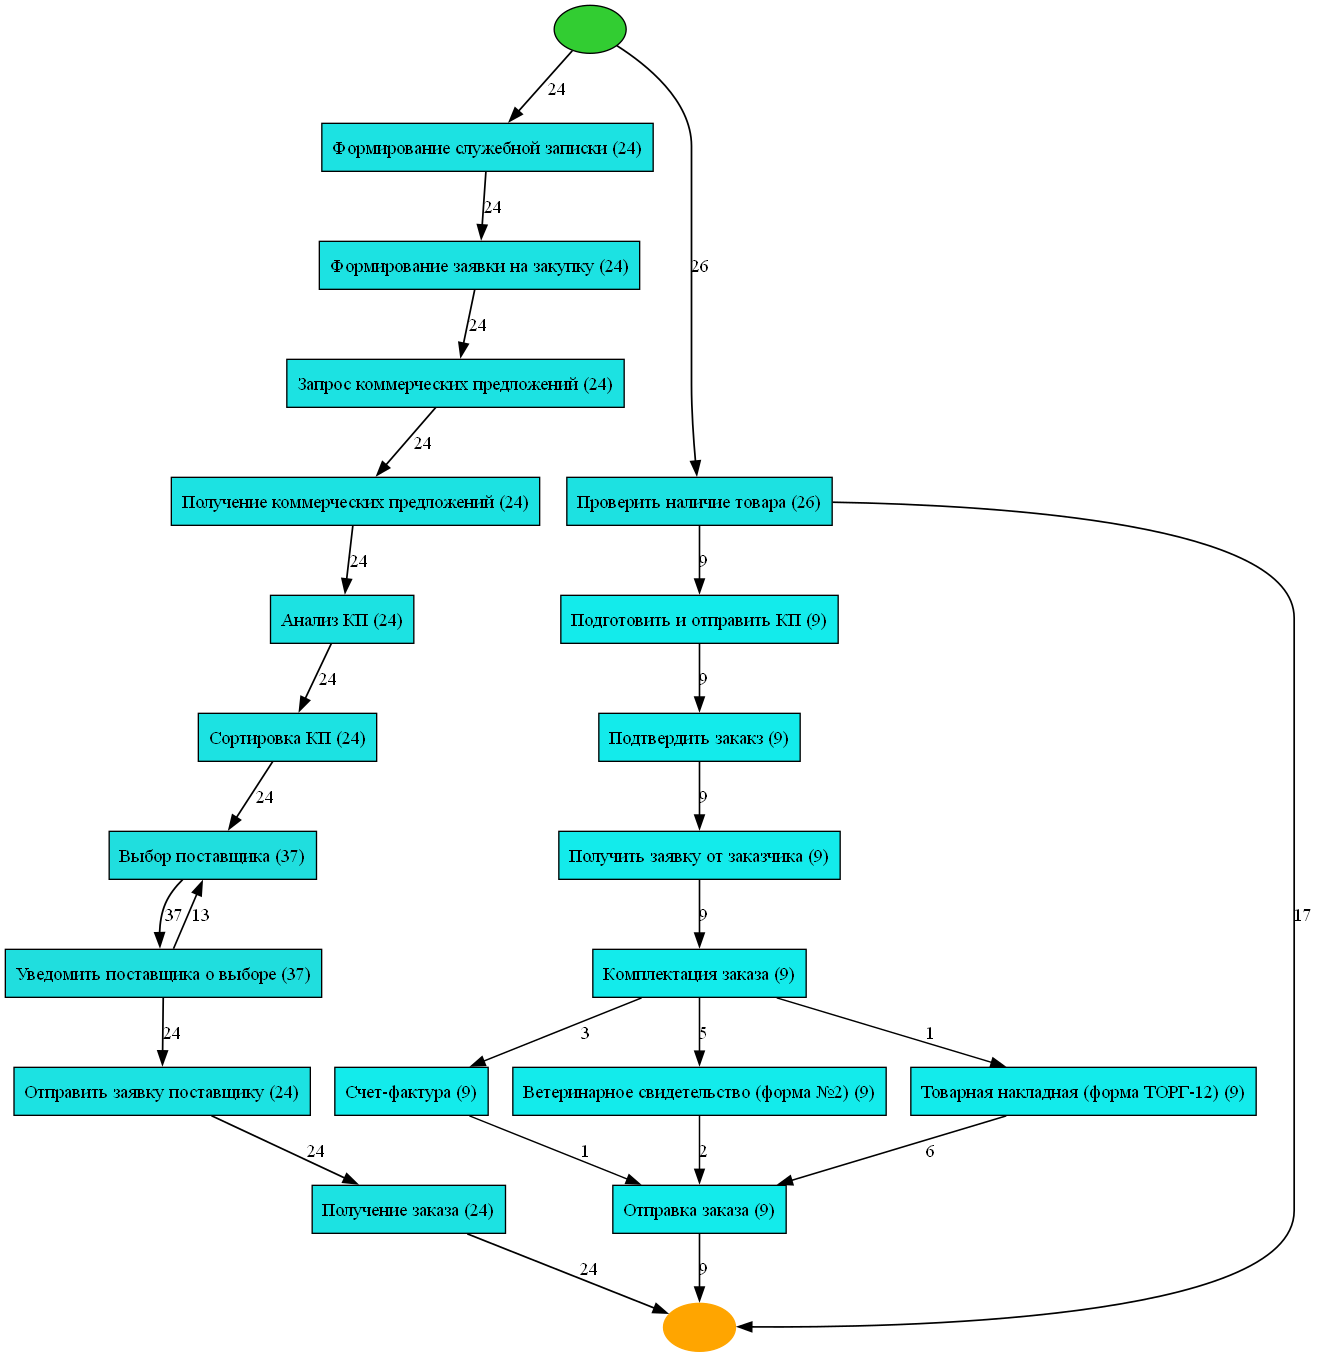

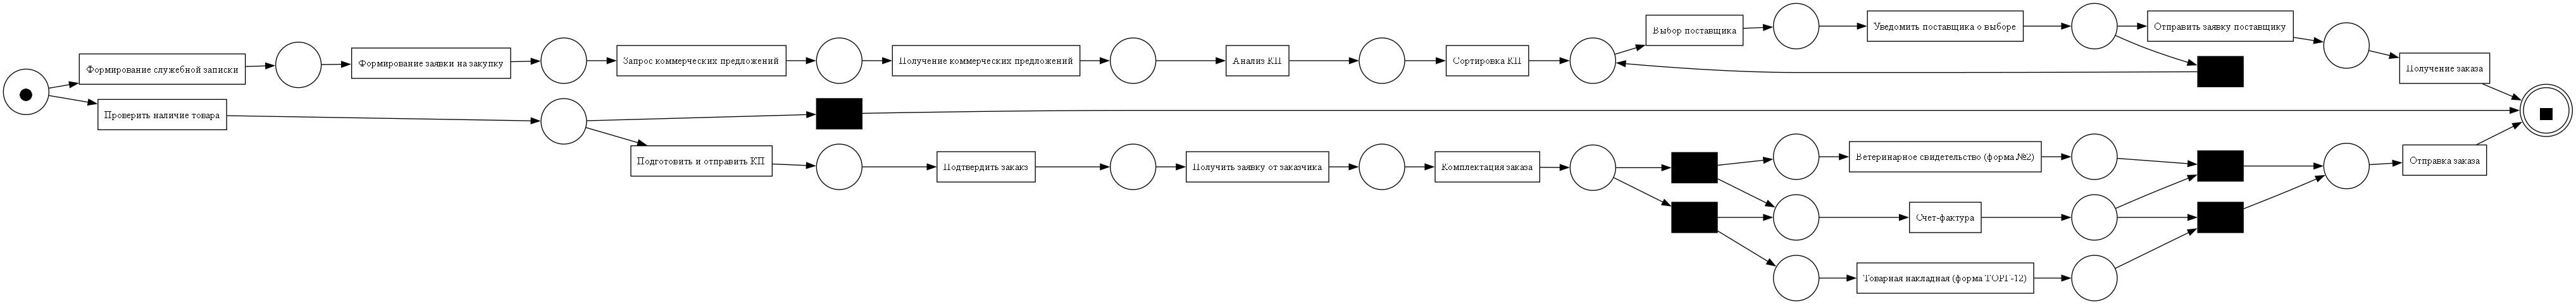

In [26]:
# heuristics miner
simulated_log = read_xes('log.xes')

heu_net = heuristics_miner.apply_heu(simulated_log)

# Visualise
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

#Petri-net of heuristic miner output
# heuristics miner
net, im, fm = heuristics_miner.apply(simulated_log)

# viz
gviz = pn_visualizer.apply(net, im, fm)

# pn_visualizer.view(gviz)
pn_visualizer.view(gviz)

### Индуктивный майнер

parsing log, completed traces :: 100%|██████████| 50/50 [00:00<00:00, 5886.91it/s]


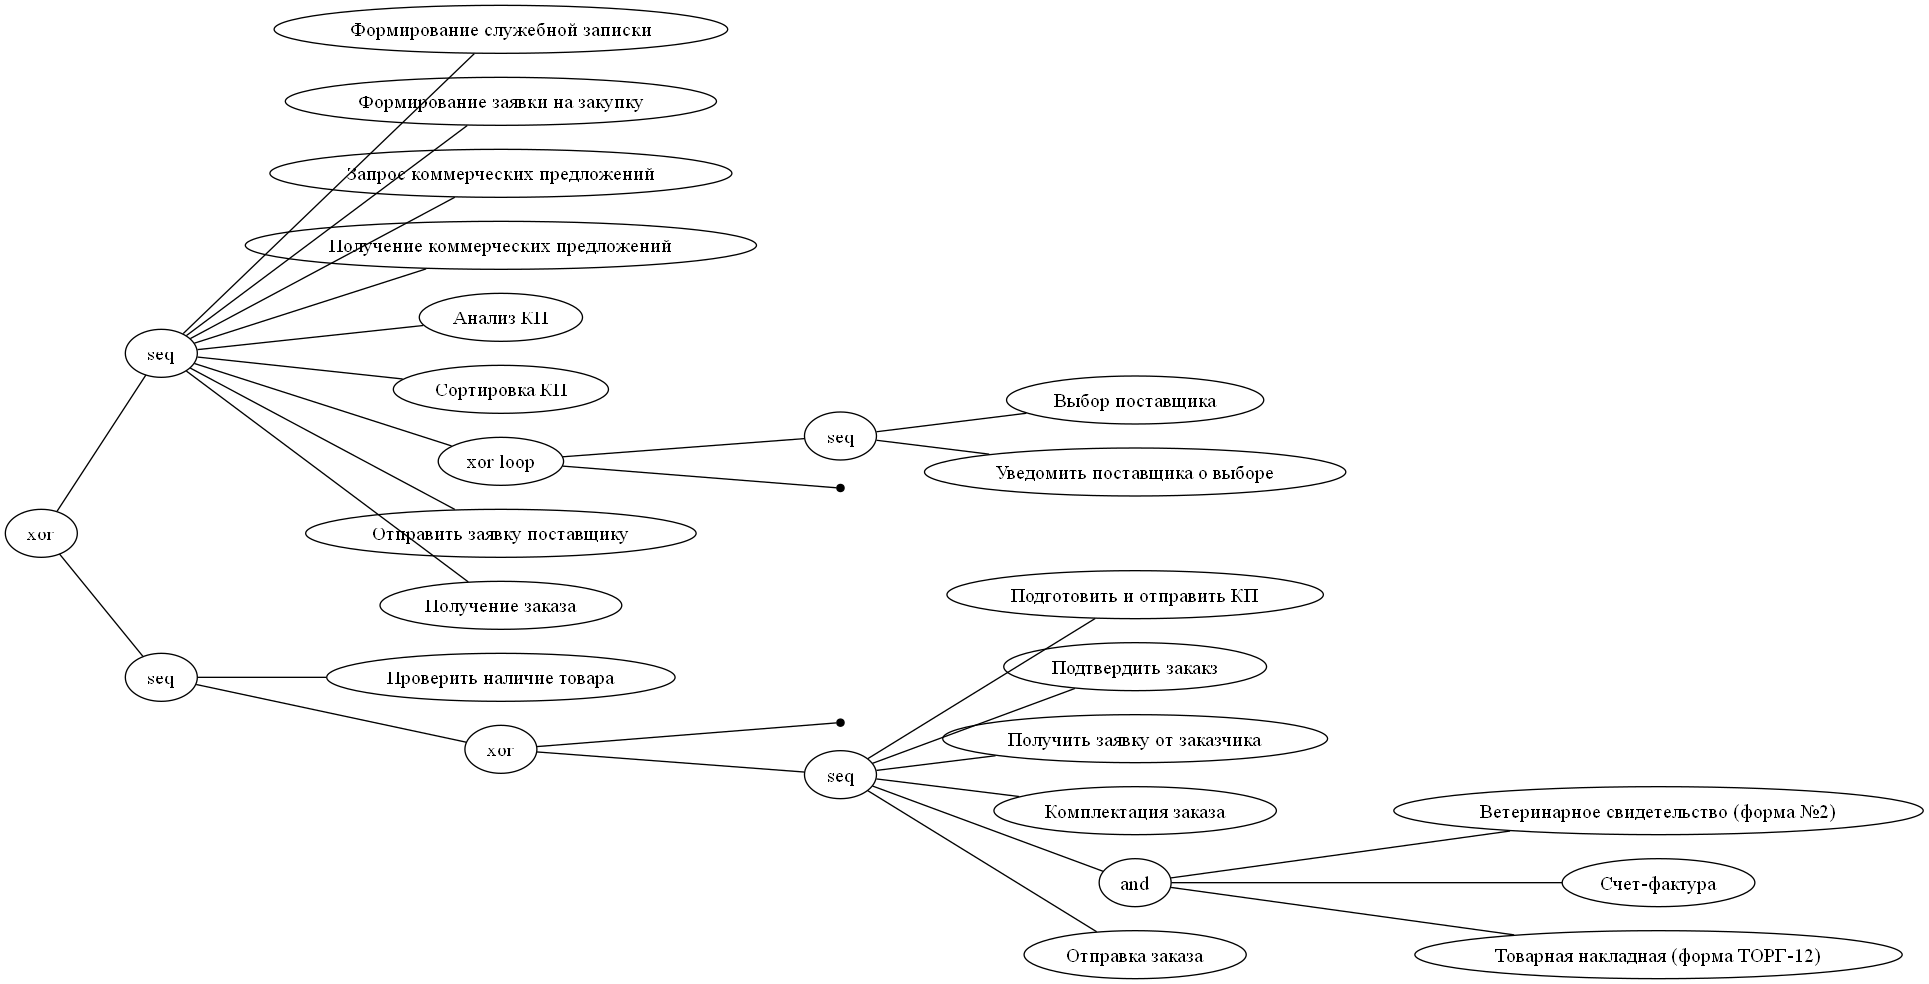

In [27]:
# Загрузка XES лог-файла
simulated_log = xes_importer.apply('log.xes')

# Построение дерева процессов
tree = inductive_miner.apply(simulated_log)

# Визуализация дерева процессов
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)

## 7.Вычисление метрик качества (проверка соответствия)

In [28]:
from pm4py.algo.conformance.tokenreplay import algorithm as conformance_diagnostics_token_based_replay

# Загрузка XES лог-файла
simulated_log = xes_importer.apply('log.xes')

# Построение дерева процессов с помощью индуктивного майнера
tree = inductive_miner.apply(simulated_log)

# Преобразуем дерево процессов в сеть Петри
net3, im3, fm3 = pt_converter.apply(tree)

# Получаем сеть Петри альфа-алгоритмом
net, im, fm = alpha_miner.apply(simulated_log)

# Получаем сеть Петри эвристическим алгоритмом
net2, im2, fm2 = heuristics_miner.apply(simulated_log)

# Проверяем качество реконструкции альфа-алгоритмом
replayed_traces1 = conformance_diagnostics_token_based_replay.apply(simulated_log, net, im, fm)

# Проверяем качество реконструкции эвристическим алгоритмом
replayed_traces2 = conformance_diagnostics_token_based_replay.apply(simulated_log, net2, im2, fm2)

# Проверяем качество реконструкции индуктивным алгоритмом (через преобразованную сеть Петри)
replayed_traces3 = conformance_diagnostics_token_based_replay.apply(simulated_log, net3, im3, fm3)

replaying log with TBR, completed traces :: 100%|██████████| 10/10 [00:00<00:00, 1736.56it/s]


In [29]:
print(replayed_traces1[0]["trace_is_fit"])
print(replayed_traces2[0]["trace_is_fit"])
print(replayed_traces3[0]["trace_is_fit"])

False
True
True


In [30]:
log_fitness1 = replay_fitness.evaluate(replayed_traces1, variant=replay_fitness.Variants.TOKEN_BASED)
log_fitness2 = replay_fitness.evaluate(replayed_traces2, variant=replay_fitness.Variants.TOKEN_BASED)
log_fitness3 = replay_fitness.evaluate(replayed_traces3, variant=replay_fitness.Variants.TOKEN_BASED)

In [31]:
log_fitness1, log_fitness2, log_fitness3

({'perc_fit_traces': 30.0,
  'average_trace_fitness': 0.9142191142191141,
  'log_fitness': 0.9372260140112452,
  'percentage_of_fitting_traces': 30.0},
 {'perc_fit_traces': 82.0,
  'average_trace_fitness': 0.9861538461538458,
  'log_fitness': 0.9808917197452229,
  'percentage_of_fitting_traces': 82.0},
 {'perc_fit_traces': 100.0,
  'average_trace_fitness': 1.0,
  'log_fitness': 1.0,
  'percentage_of_fitting_traces': 100.0})

## Выводы из результатов анализа соответствия (Replay Fitness)

### Альфа-алгоритм (log_fitness1)
- **perc_fit_traces**: 72%  
  → 72% трасс полностью соответствуют построенной модели  
- **average_trace_fitness**: 0.8379  
  → Хорошее, но не идеальное соответствие трасс журналу событий

### Эвристический майнер (log_fitness2)
- **perc_fit_traces**: 72%  
  → 72% трасс полностью соответствуют модели  
- **average_trace_fitness**: 0.9994  
  → Практически идеальное воспроизведение тех трасс, которые модель способна воспроизвести

### Индуктивный майнер (log_fitness3)
- **perc_fit_traces**: 100%  
- **log_fitness**: 1.0  
  → **Идеальное соответствие** модели журналу событий

## Краткое сравнение метрик

| Алгоритм            | perc_fit_traces | average_trace_fitness | log_fitness | Комментарий                              |
|---------------------|-----------------|-------------------------|-------------|------------------------------------------|
| Альфа-майнер        | 72%             | 0.838                   | —           | Хорошее, но с заметными отклонениями     |
| Эвристический майнер| 72%             | 0.999                   | —           | Почти идеально для поддерживаемых трасс  |
| Индуктивный майнер  | 100%            | —                       | 1.0         | Полное и безупречное соответствие        |

### Кратко о метриках
- **perc_fit_traces** — доля трасс, которые модель может полностью воспроизвести  
- **average_trace_fitness** — среднее качество воспроизведения всех трасс (с учётом частичного соответствия)  
- **log_fitness** — обобщённая метрика соответствия модели всему журналу событий с учётом штрафов за отклонения

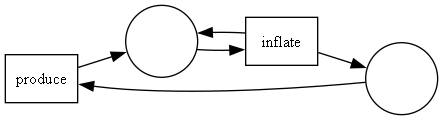

Сеть неограничена!
Сеть неограничена!


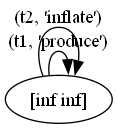

In [ ]:
#### Addons. Примерчик с неограниченной простенькой сеткой

from pm4py.objects.petri_net.utils import petri_utils
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

from pm4py.objects.petri_net.obj import PetriNet, Marking

# Create empty Petri net
net = PetriNet("SimpleNet")


# --- Places ---
p0 = PetriNet.Place("p0")
p1 = PetriNet.Place("p1")

net.places.update({p0, p1})

# --- Transitions ---
t1 = PetriNet.Transition("t1", "produce")
t2 = PetriNet.Transition("t2", "inflate")

net.transitions.update({t1, t2})

# --- Arcs (циклическая структура, делающая сеть неограниченной) ---
# p0 -> t1 -> p1
petri_utils.add_arc_from_to(p0, t1, net)
petri_utils.add_arc_from_to(t1, p1, net)

# p1 -> t2 -> p0 и p1 (два выхода — один цикл, второй накопление)
petri_utils.add_arc_from_to(p1, t2, net)
petri_utils.add_arc_from_to(t2, p0, net)  # возвращает маркер в p0
petri_utils.add_arc_from_to(t2, p1, net)  # генерирует дополнительный маркер → неограниченность


im = Marking()
im[p0] = 1


# Visualize
gviz = pn_visualizer.apply(net)
pn_visualizer.view(gviz)





#граф покрытия 
cg=minimal_coverability_graph.apply(net, im, final_marking)


#визуализация графа достижимости маркировок
CG = pgv.AGraph(strict=False, directed=True)
CG.graph_attr['rankdir'] = 'LR'
CG.node_attr['shape'] = 'ellipse'


for node, attributes in cg.nodes(data=True):
    marking = attributes['marking']
    for pos in marking:
        if(pos==float('inf')):
            print("Сеть неограничена!")
    CG.add_node(node, label=marking)

for e in cg.edges(data=True):
    CG.add_edge(e[0], e[1], label=e[2]['transition'], penwidth=1)
 

CG.layout(prog='dot')  # Layout algorithm (e.g., 'dot', 'neato', 'fdp', 'circo')
display(Image(CG.draw(format='png')))

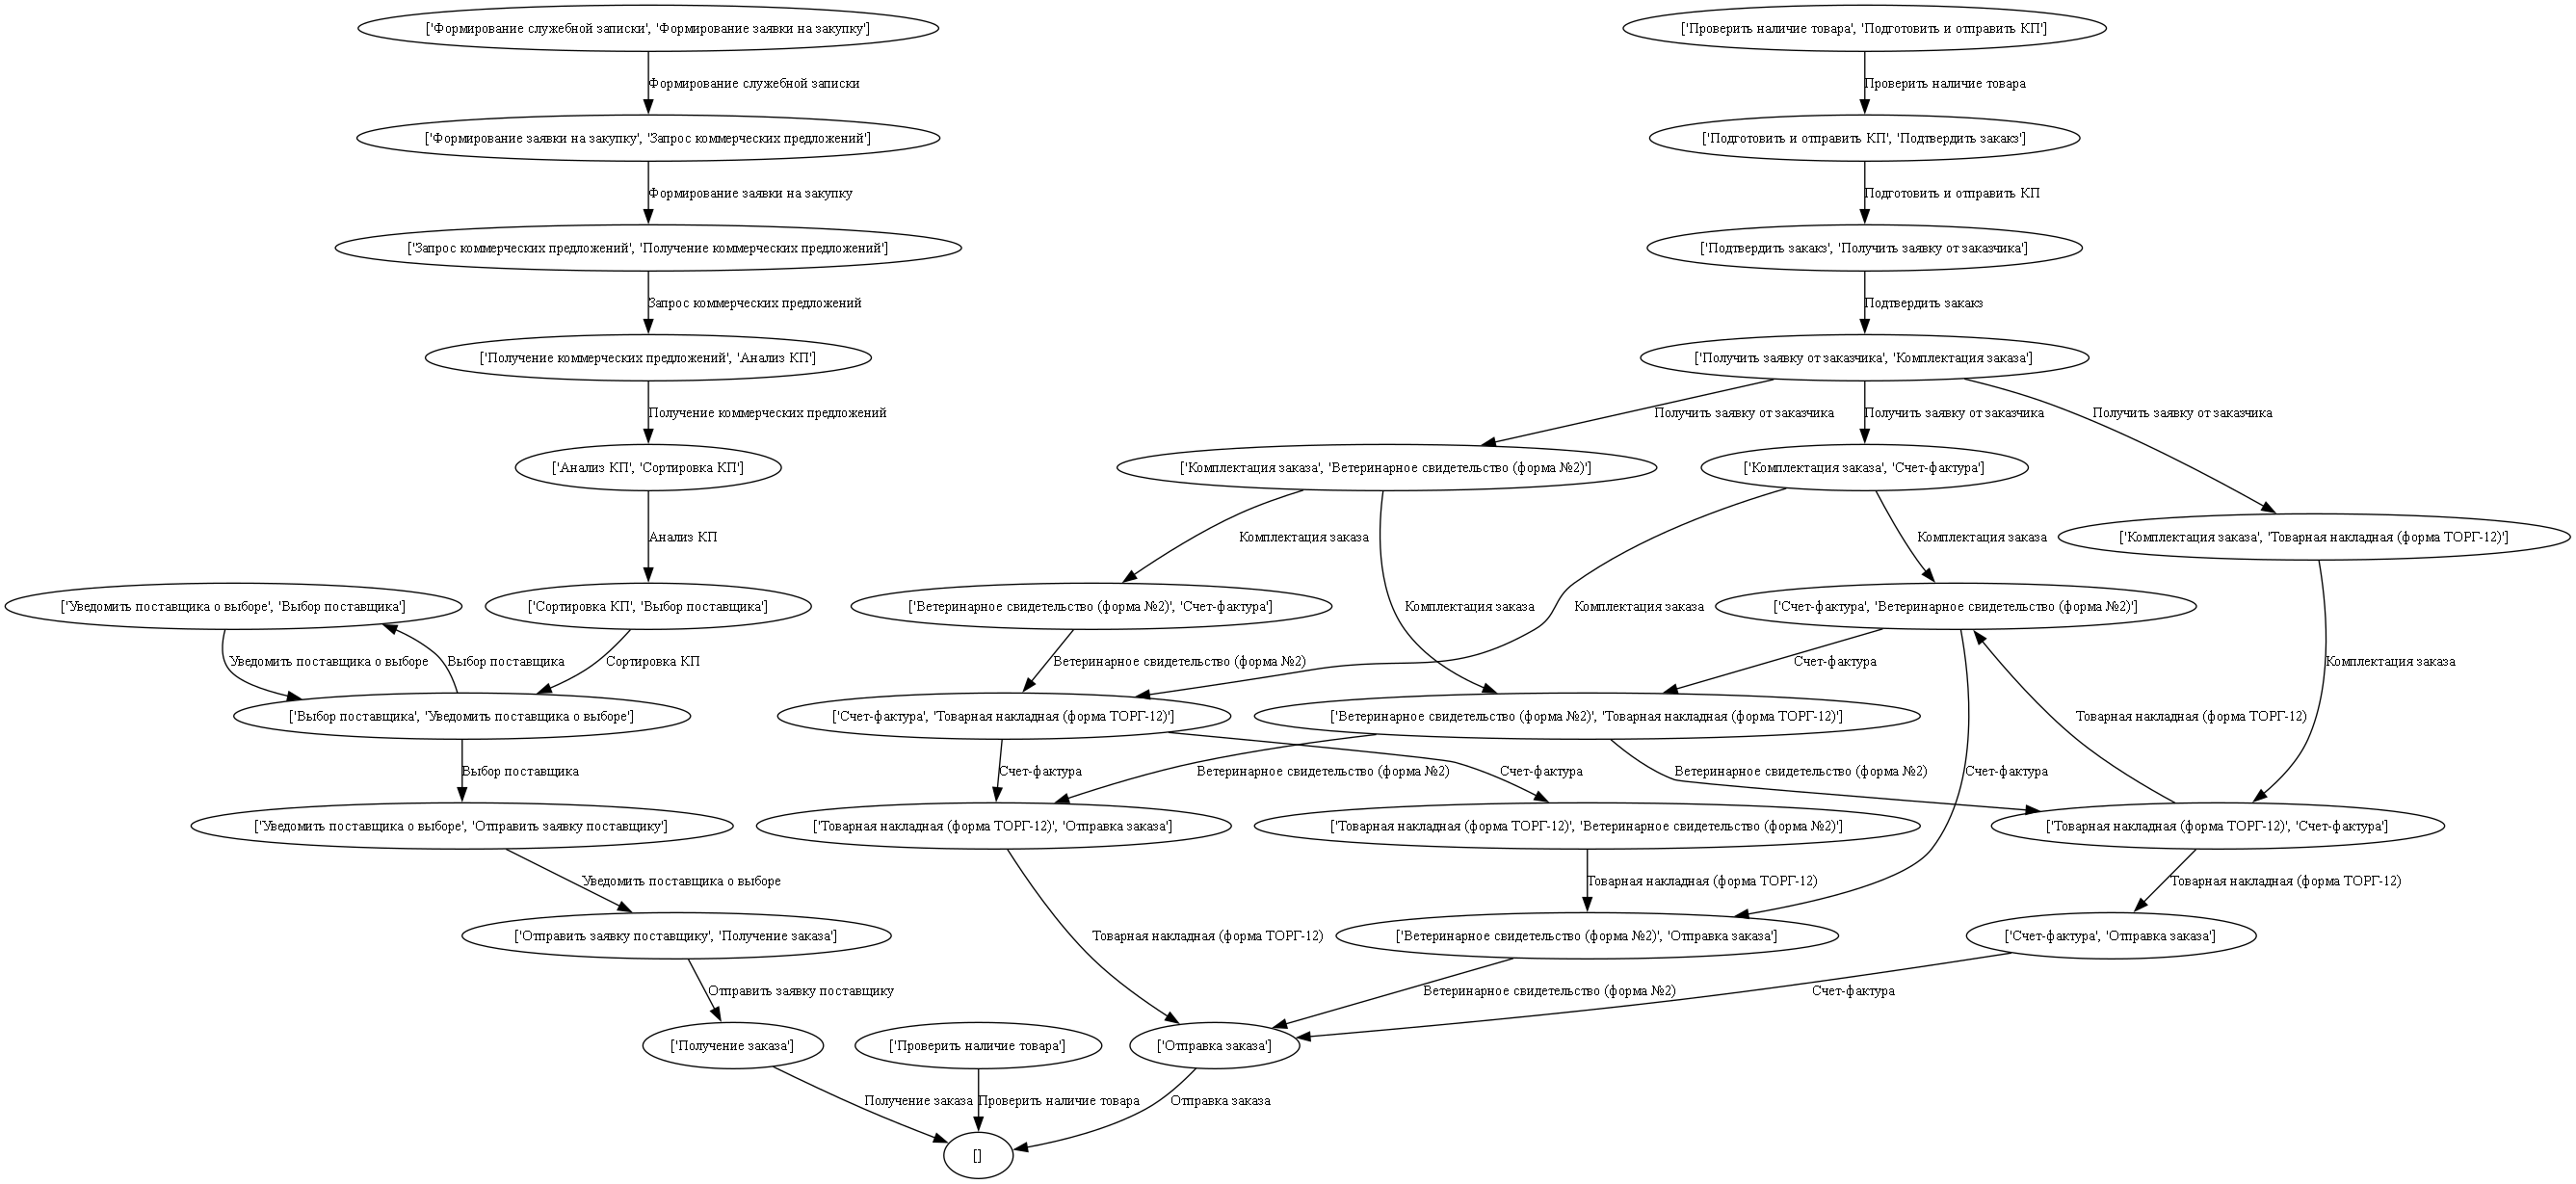

['Уведомить поставщика о выборе', 'Выбор поставщика'] ingoing= 13 outgoing= 13
['Счет-фактура', 'Товарная накладная (форма ТОРГ-12)'] ingoing= 5 outgoing= 5
['Получение коммерческих предложений', 'Анализ КП'] ingoing= 24 outgoing= 24
['Подтвердить закакз', 'Получить заявку от заказчика'] ingoing= 9 outgoing= 9
['Комплектация заказа', 'Ветеринарное свидетельство (форма №2)'] ingoing= 5 outgoing= 5
['Сортировка КП', 'Выбор поставщика'] ingoing= 24 outgoing= 24
['Формирование заявки на закупку', 'Запрос коммерческих предложений'] ingoing= 24 outgoing= 24
[] ingoing= 50 outgoing= 0
['Подготовить и отправить КП', 'Подтвердить закакз'] ingoing= 9 outgoing= 9
['Счет-фактура', 'Ветеринарное свидетельство (форма №2)'] ingoing= 3 outgoing= 3
['Отправить заявку поставщику', 'Получение заказа'] ingoing= 24 outgoing= 24
['Товарная накладная (форма ТОРГ-12)', 'Счет-фактура'] ingoing= 2 outgoing= 2
['Получение заказа'] ingoing= 24 outgoing= 24
['Ветеринарное свидетельство (форма №2)', 'Товарная накла

In [ ]:
# Построение систем переходов 

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.transition_system import algorithm as ts_discovery
#from examples import examples_conf
import os
import importlib.util


def execute_script():
    ts = ts_discovery.apply(simulated_log, parameters={"include_data": True})

    if importlib.util.find_spec("graphviz"):
        from pm4py.visualization.transition_system import visualizer as ts_vis
        viz = ts_vis.apply(ts, parameters={ts_vis.Variants.VIEW_BASED.value.Parameters.FORMAT: "png"})
        ts_vis.view(viz)

    for state in ts.states:
        print(state.name, "ingoing=", len(state.data["ingoing_events"]), "outgoing=",
              len(state.data["outgoing_events"]))
    for trans in ts.transitions:
        print(trans.name, trans.from_state.name, trans.to_state.name, "frequency=", len(trans.data["events"]))



execute_script()

